<a href="https://colab.research.google.com/github/Sibu08/movierecommendation/blob/master/MovieLens25M_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import gc
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [0]:
ratings = pd.read_csv('/content/drive/My Drive/DS Project 20M/ratings.csv')

In [0]:
movies = pd.read_csv('/content/drive/My Drive/DS Project 20M/movies.csv')

In [0]:
total=ratings.merge(movies,on='movieId',how='inner')
total['genres']=total['genres'].apply(lambda x: x.split('|'))

In [0]:
active_users = pd.read_csv('/content/drive/My Drive/DS Project 20M/ActiveUsers.csv')

In [0]:
total = total[total.userId.isin(active_users['userId'].tolist())]

In [0]:
total

,userId,movieId,rating,timestamp,title,genres
1,3,296,5.0,1439474476,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
12,19,296,3.5,1466674637,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
90,187,296,4.5,1277374442,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
140,284,296,4.5,1431924674,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
173,357,296,3.5,1367156671,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
...,...,...,...,...,...,...
25000073,162067,203064,2.5,1560035272,The Hotshots (1968),[Comedy]
25000074,162271,92648,3.0,1327978630,BookWars (2000),"[Comedy, Crime, Documentary]"
25000075,162271,92946,1.0,1329627154,"Souler Opposite, The (1998)","[Comedy, Romance]"
25000076,162271,95230,2.5,1340566357,Macbeth in Manhattan (1999),[Drama]


## ***Timestamp***

In [0]:
total.describe()['timestamp']['75%']

1454200478.0

In [0]:
test_75 = total[total['timestamp'] <= 1454200478.0]

In [0]:
test_25 = total[total['timestamp'] > 1454200478.0]

In [0]:
common = list(set(test_75['userId'].unique()).intersection(set(test_25['userId'].unique())))

In [0]:
test_75

,userId,movieId,rating,timestamp,title,genres
1,3,296,5.0,1439474476,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
90,187,296,4.5,1277374442,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
140,284,296,4.5,1431924674,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
173,357,296,3.5,1367156671,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
179,368,296,5.0,1402798200,Pulp Fiction (1994),"[Comedy, Crime, Drama, Thriller]"
...,...,...,...,...,...,...
25000058,162067,114365,2.5,1445788103,Wer's glaubt wird selig (2012),[Comedy]
25000059,162067,150610,2.5,1452554148,Der böse Onkel (2013),"[Comedy, Drama]"
25000074,162271,92648,3.0,1327978630,BookWars (2000),"[Comedy, Crime, Documentary]"
25000075,162271,92946,1.0,1329627154,"Souler Opposite, The (1998)","[Comedy, Romance]"


## **Predicting From Clusters**

In [0]:
test75_matrix = test_75.pivot_table(index='userId',columns='movieId',values='rating')

In [0]:
test75_matrix = test75_matrix.fillna(0.0)

In [0]:
X = test75_matrix.iloc[:, :].values

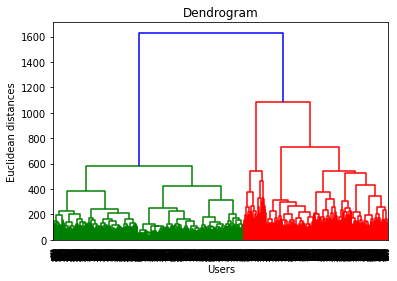

In [0]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method  = "ward"))
plt.title('Dendrogram')
plt.xlabel('Users')
plt.ylabel('Euclidean distances')
plt.show()

In [0]:
from sklearn.cluster import AgglomerativeClustering 
hc = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage ='ward')
y_hc = hc.fit_predict(X)

In [0]:
y_hc

array([3, 0, 1, ..., 0, 2, 3])

In [0]:
import collections
collections.Counter(y_hc)

Counter({0: 2340, 1: 913, 2: 262, 3: 591})

In [0]:
xyz = pd.concat([pd.DataFrame(test75_matrix.index.tolist(), columns = ['userId']), pd.DataFrame(y_hc, columns = ['Cluster'])], axis = 1)

In [0]:
xyz

,userId,Cluster
0,3,3
1,19,0
2,187,1
3,284,0
4,357,0
...,...,...
4101,162482,0
4102,162498,0
4103,162512,0
4104,162516,2


In [0]:
ratings = pd.merge(ratings, ratings.groupby('movieId', as_index = False)['rating'].count(), on = 'movieId')

In [0]:
ratings = ratings.rename(columns = {'rating_x': 'rating', 'rating_y': 'count_num'})

In [0]:
gc.collect()

11

## **Cluster 1**

In [0]:
temp1 = xyz[xyz['Cluster'] == 0]
temp1

,userId,Cluster
1,19,0
3,284,0
4,357,0
5,368,0
6,402,0
...,...,...
4099,162390,0
4100,162467,0
4101,162482,0
4102,162498,0


In [0]:
cluster_1 = pd.merge(ratings, temp1, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_1.drop(columns = ['Cluster', 'timestamp'], inplace = True)

In [0]:
cluster_1=pd.DataFrame(cluster_1.groupby(['movieId', 'count_num']).agg(count_rate=pd.NamedAgg(column='rating', aggfunc='mean')))

In [0]:
cluster_1 = cluster_1.reset_index()

In [0]:
cluster_1

,movieId,count_num,count_rate
0,1,57309,3.686062
1,2,24228,3.133504
2,3,11804,2.976190
3,4,2523,2.333333
4,5,11714,2.559028
...,...,...,...
29991,209123,1,4.000000
29992,209129,1,4.500000
29993,209131,1,3.500000
29994,209159,1,3.000000


## **Cluster 2**

In [0]:
temp2 = xyz[xyz['Cluster'] == 1]
temp2

,userId,Cluster
2,187,1
8,426,1
12,653,1
20,939,1
22,1203,1
...,...,...
4069,160858,1
4074,161047,1
4081,161378,1
4090,161928,1


In [0]:
cluster_2 = pd.merge(ratings, temp2, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_2.drop(columns = ['Cluster', 'timestamp'], inplace = True)

In [0]:
cluster_2=pd.DataFrame(cluster_2.groupby(['movieId', 'count_num']).agg(count_rate=pd.NamedAgg(column='rating', aggfunc='mean')))

In [0]:
cluster_2 = cluster_2.reset_index()

In [0]:
cluster_2

,movieId,count_num,count_rate
0,1,57309,3.826467
1,2,24228,3.014555
2,3,11804,2.858696
3,4,2523,2.390625
4,5,11714,2.713918
...,...,...,...
32507,208889,2,3.000000
32508,208939,8,4.000000
32509,208941,1,3.000000
32510,209069,1,3.000000


## **Cluster 3**

In [0]:
temp3 = xyz[xyz['Cluster'] == 2]
temp3

,userId,Cluster
14,803,2
16,847,2
33,1748,2
36,1831,2
44,1977,2
...,...,...
4047,159816,2
4056,160219,2
4062,160540,2
4094,162271,2


In [0]:
cluster_3 = pd.merge(ratings, temp3, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_3.drop(columns = ['Cluster', 'timestamp'], inplace = True)

In [0]:
cluster_3=pd.DataFrame(cluster_3.groupby(['movieId', 'count_num']).agg(count_rate=pd.NamedAgg(column='rating', aggfunc='mean')))

In [0]:
cluster_3 = cluster_3.reset_index()

In [0]:
cluster_3

,movieId,count_num,count_rate
0,1,57309,4.128099
1,2,24228,3.036810
2,3,11804,2.915842
3,4,2523,2.546512
4,5,11714,2.813131
...,...,...,...
42186,208939,8,4.000000
42187,209049,1,4.500000
42188,209051,1,3.500000
42189,209121,1,4.000000


## **Cluster 4**

In [0]:
temp4 = xyz[xyz['Cluster'] == 3]
temp4

,userId,Cluster
0,3,3
15,815,3
25,1232,3
39,1881,3
50,2375,3
...,...,...
4080,161342,3
4084,161560,3
4096,162326,3
4097,162334,3


In [0]:
cluster_4 = pd.merge(ratings, temp4, left_on = 'userId', right_on = 'userId')

In [0]:
cluster_4.drop(columns = ['Cluster', 'timestamp'], inplace = True)

In [0]:
cluster_4=pd.DataFrame(cluster_4.groupby(['movieId', 'count_num']).agg(count_rate=pd.NamedAgg(column='rating', aggfunc='mean')))

In [0]:
cluster_4 = cluster_4.reset_index()

In [0]:
cluster_4

,movieId,count_num,count_rate
0,1,57309,3.882474
1,2,24228,3.332845
2,3,11804,3.400000
3,4,2523,1.000000
4,5,11714,2.861111
...,...,...,...
17948,208905,1,2.000000
17949,208907,1,1.000000
17950,208909,1,2.000000
17951,208911,1,4.000000


## **Results**

In [0]:
test_25 = test_25[test_25['userId'].isin(xyz.userId.tolist())]

In [0]:
test_25 = pd.DataFrame(test_25.groupby(['userId'])['movieId'].unique())

In [0]:
test_25 = test_25.reset_index()

In [0]:
test_25 = pd.merge(test_25, xyz, on = 'userId')

## **Cross Validation**

In [0]:
mean_dict = {}
for k in range(2000, 4501, 200):
  for j in range(2000, 3001, 100):
    cluster_1_movies = (cluster_1[cluster_1['count_num'] > k].nlargest(j, 'count_rate')).movieId.tolist()
    cluster_2_movies = (cluster_2[cluster_2['count_num'] > k].nlargest(j, 'count_rate')).movieId.tolist()
    cluster_3_movies = (cluster_3[cluster_3['count_num'] > k].nlargest(j, 'count_rate')).movieId.tolist()
    cluster_4_movies = (cluster_4[cluster_4['count_num'] > k].nlargest(j, 'count_rate')).movieId.tolist()
    movie_dict = {0 : cluster_1_movies, 1 : cluster_2_movies, 2 : cluster_3_movies, 3 : cluster_4_movies}
    test_25['moviesPredicted'] = test_25['Cluster'].apply(lambda x : movie_dict[x])
    test_25['correctPredictions'] = 0
    test_25['recall'] = 0.0
    for i in test_25.index:
      test_25.loc[i, 'correctPredictions'] = len(set(test_25.iloc[i]['movieId']).intersection(set(test_25.iloc[i]['moviesPredicted'])))
    for i in test_25.index:
      test_25.loc[i, 'recall'] = round(float(test_25.iloc[i]['correctPredictions'])/float(len(test_25.iloc[i]['movieId'])), 2)
    mean_dict[(k, j)] = test_25.describe()['recall']['mean']

In [0]:
mean_dict

{(2000, 2000): 0.5985776911836328,
 (2000, 2100): 0.6132001948368235,
 (2000, 2200): 0.6235289819775947,
 (2000, 2300): 0.6349342425718466,
 (2000, 2400): 0.6430418899171939,
 (2000, 2500): 0.6445908426692645,
 (2000, 2600): 0.6445908426692645,
 (2000, 2700): 0.6445908426692645,
 (2000, 2800): 0.6445908426692645,
 (2000, 2900): 0.6445908426692645,
 (2000, 3000): 0.6445908426692645,
 (2200, 2000): 0.6003336580613732,
 (2200, 2100): 0.6118631271310283,
 (2200, 2200): 0.6225085241110572,
 (2200, 2300): 0.6292425718460791,
 (2200, 2400): 0.6292425718460791,
 (2200, 2500): 0.6292425718460791,
 (2200, 2600): 0.6292425718460791,
 (2200, 2700): 0.6292425718460791,
 (2200, 2800): 0.6292425718460791,
 (2200, 2900): 0.6292425718460791,
 (2200, 3000): 0.6292425718460791,
 (2400, 2000): 0.5983999025815878,
 (2400, 2100): 0.6092985874330248,
 (2400, 2200): 0.6146809547004375,
 (2400, 2300): 0.6146809547004375,
 (2400, 2400): 0.6146809547004375,
 (2400, 2500): 0.6146809547004375,
 (2400, 2600): 0.614

In [0]:
  cluster_1_movies = (cluster_1[cluster_1['count_num'] > 2000].nlargest(2500, 'count_rate')).movieId.tolist()
  cluster_2_movies = (cluster_2[cluster_2['count_num'] > 2000].nlargest(2500, 'count_rate')).movieId.tolist()
  cluster_3_movies = (cluster_3[cluster_3['count_num'] > 2000].nlargest(2500, 'count_rate')).movieId.tolist()
  cluster_4_movies = (cluster_4[cluster_4['count_num'] > 2000].nlargest(2500, 'count_rate')).movieId.tolist()
  movie_dict = {0 : cluster_1_movies, 1 : cluster_2_movies, 2 : cluster_3_movies, 3 : cluster_4_movies}
  test_25['moviesPredicted'] = test_25['Cluster'].apply(lambda x : movie_dict[x])
  test_25['correctPredictions'] = 0
  test_25['recall'] = 0.0
  for i in test_25.index:
    test_25.loc[i, 'correctPredictions'] = len(set(test_25.iloc[i]['movieId']).intersection(set(test_25.iloc[i]['moviesPredicted'])))
  for i in test_25.index:
    test_25.loc[i, 'recall'] = round(float(test_25.iloc[i]['correctPredictions'])/float(len(test_25.iloc[i]['movieId'])), 2)

In [0]:
test_25

,userId,movieId,Cluster,moviesPredicted,correctPredictions,recall
0,3,"[6711, 8360, 3948, 5574, 6879, 7143, 29, 111, ...",3,"[2111, 663, 318, 2677, 2959, 2571, 58559, 1694...",165,0.72
1,19,"[296, 1722, 1907, 2273, 2294, 293, 3328, 31878...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",20,0.42
2,187,"[1909, 109487, 122886, 134130, 152081, 165483,...",1,"[318, 858, 1203, 296, 1221, 2959, 1201, 1193, ...",5,0.71
3,284,"[3949, 7361, 8360, 8873, 527, 1080, 1201, 1584...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",168,0.84
4,357,"[1485, 3300, 4992, 45672, 48780, 51255, 53121,...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",56,0.49
...,...,...,...,...,...,...
4101,162482,"[135143, 139385, 148626, 158966, 164179, 16652...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",9,0.60
4102,162498,"[63876, 1104, 87522, 72949, 90592]",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",2,0.40
4103,162512,"[4299, 40815, 1732, 4027, 4344, 4369, 4816, 54...",0,"[318, 1203, 2959, 195159, 44555, 296, 7156, 85...",60,0.91
4104,162516,"[6539, 7323, 54648, 59615, 60074, 87430, 89753...",2,"[858, 1221, 912, 318, 1198, 527, 1203, 904, 26...",87,0.36


In [0]:
test_25.describe()

,userId,Cluster,correctPredictions,recall
count,4106.000000,4106.000000,4106.000000,4106.000000
mean,80964.650024,0.781783,96.834145,0.644591
std,46507.980450,1.078014,131.581206,0.233974
min,3.000000,0.000000,0.000000,0.000000
25%,40769.000000,0.000000,21.000000,0.480000
50%,80243.000000,0.000000,55.000000,0.670000
75%,121489.500000,1.000000,121.000000,0.830000
max,162521.000000,3.000000,1603.000000,1.000000
